# Practice Session 03: Networks from text

*Introduction to Network Science* (2025/26), UPF

Author: <font color="blue">Joan Cardona</font>

E-mail: <font color="blue">joan.cardona02@estudiant.upf.edu</font>

Date: <font color="blue">16/10/25</font>

# 1. Create the directed mention network

In [1]:
import io
import json
import gzip
import csv
import re

In [2]:
# Input file
COMPRESSED_INPUT_FILENAME = "data/CovidLockdownCatalonia.json.gz"   # You may need to change this filepath depending on where you've saved the data file

# These are the output files, leave as-is
OUTPUT_ALL_EDGES_FILENAME = "CovidLockdownCatalonia.csv"
OUTPUT_FILTERED_EDGES_FILENAME = "CovidLockdownCatalonia-min-weight-filtered.csv"
OUTPUT_CO_MENTIONS_FILENAME = "CovidLockdownCatalonia-co-mentions.csv"

## 1.1. Extract mentions

In [3]:
# Leave this code as-is

def extract_mentions(text):
    return re.findall("@([a-zA-Z0-9_]{5,20})", text)

print(extract_mentions("RT @elnacionalcat: check this post by @en_blau"))

['elnacionalcat', 'en_blau']


## 1.2. Count mentions


In [4]:
with gzip.open(COMPRESSED_INPUT_FILENAME, "rt", encoding="utf-8") as input_file:
    mentions_counter = {}
    for line in input_file:
        tweet = json.loads(line)
        author = tweet["user"]["screen_name"]
        text = tweet["full_text"]
        mentions = extract_mentions(text)
        for mention in mentions:
            key = (author, mention)
            mentions_counter[key] = mentions_counter.get(key, 0) + 1
            

        

Print the number of times the account `joanmariapique` mentioned `catalangov`. It should be 9.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [5]:
print(mentions_counter[('joanmariapique', 'catalangov')])

9


In [6]:
seen_pairs = set()

for (u,v), count in mentions_counter.items():
    pair = tuple(sorted((u, v)))
    total = count + mentions_counter.get((v, u), 0)
    if total > 8 and pair not in seen_pairs:
        seen_pairs.add(pair)
        print(f"Accounts @{pair[0]} and @{pair[1]} mention each other {total} times")

Accounts @updayESP and @wualaswold1 mention each other 9 times
Accounts @DrTedros and @emocionycambio mention each other 16 times
Accounts @FXstreetNews and @HareshMenghani mention each other 11 times
Accounts @MargaXrepublica and @MargaXrepublica mention each other 12 times
Accounts @DrEricDing and @Txesnut1 mention each other 11 times
Accounts @catalangov and @joanmariapique mention each other 9 times


## 1.3 Save network

In [7]:
# Leave this code as-is

lines_written = 0

with io.open(OUTPUT_ALL_EDGES_FILENAME, "w") as output_file:
    writer = csv.writer(output_file, delimiter='\t', quotechar='"')
    writer.writerow(["Source", "Target", "Weight"])
    for key in mentions_counter:
        author = key[0]
        mention = key[1]
        weight = mentions_counter[key]
        writer.writerow([author, mention, weight])
        lines_written += 1

print(f"Wrote {lines_written} lines to file {OUTPUT_ALL_EDGES_FILENAME}")

Wrote 34040 lines to file CovidLockdownCatalonia.csv


In [8]:
lines_written = 0

with io.open(OUTPUT_FILTERED_EDGES_FILENAME, "w", encoding="utf-8") as output_file:
    writer = csv.writer(output_file, delimiter="\t", quotechar='"')
    writer.writerow(["Source", "Target", "Weight"])
    for (author, mention), weight in mentions_counter.items():
        if weight >= 3:
            writer.writerow([author, mention, weight])
            lines_written += 1

print(f"Wrote {lines_written} lines to file {OUTPUT_FILTERED_EDGES_FILENAME}")


Wrote 255 lines to file CovidLockdownCatalonia-min-weight-filtered.csv


# 2. Visualize the directed mention network


In [9]:
# Import required packages

import networkx as nx
import matplotlib.pyplot as plt

In [10]:
g = nx.DiGraph()

with open(OUTPUT_FILTERED_EDGES_FILENAME, "r", encoding="utf-8") as input_file:
    reader = csv.DictReader(input_file, delimiter="\t")
    for row in reader:
        source = row["Source"]
        target = row["Target"]
        weight = int(row["Weight"])
        g.add_edge(source, target, weight=weight)


In [11]:
# Leave this code as-is

list(nx.get_edge_attributes(g, 'weight').items())[:10]

[(('AlfonsGorina', 'movieweb'), 5),
 (('McIslamofobia', 'carlesplb'), 3),
 (('marsicilia', 'javiernegre10'), 4),
 (('wualaswold1', 'updayESP'), 9),
 (('RedPillDetox', 'TomthunkitsMind'), 7),
 (('SpanishDan1', 'fascinatorfun'), 8),
 (('SpanishDan1', 'g_gosden'), 6),
 (('SpanishDan1', 'BorisJohnson'), 4),
 (('SpanishDan1', 'miffythegamer'), 6),
 (('SpanishDan1', 'Haggis_UK'), 4)]

## 2.1. Extract the largest connected component using NetworkX

In [12]:
# Leave this code as-is

print(f"The network is weakly connected: {nx.is_weakly_connected(g)}")
print(f"The network is strongly connected: {nx.is_strongly_connected(g)}")

The network is weakly connected: False
The network is strongly connected: False


In [13]:
largest = max(nx.weakly_connected_components(g), key=len)

lcc = g.subgraph(largest).copy()

To validate, we can check the connectedness of this subgraph.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [14]:
# Leave this code as-is

print(f"The network is weakly connected: {nx.is_weakly_connected(lcc)}")
print(f"The network is strongly connected: {nx.is_strongly_connected(lcc)}")

The network is weakly connected: True
The network is strongly connected: False


## 2.2. Visualize the largest connected component


In [15]:
G_und = lcc.to_undirected()

edge_btwn = nx.edge_betweenness_centrality(G_und, weight="weight", normalized=True)

for u, v in lcc.edges():
    lcc[u][v]["betweenness"] = edge_btwn.get((u, v), edge_btwn.get((v, u), 0.0))

The below code outputs the top 10 edges by betweenness.

<font size="-1" color="gray">(Remove this cell when delivering.)</font>

In [16]:
# Leave this code as-is

top_edges = sorted(lcc.edges(data=True), key=lambda x: x[2]['betweenness'], reverse=True)[:10]
for edge in top_edges:
    print(f"Edge from @{edge[0]} to @{edge[1]} has betweenness {edge[2]['betweenness']:.3f}")

Edge from @joanmariapique to @sanchezcastejon has betweenness 0.347
Edge from @joanmariapique to @emergenciescat has betweenness 0.345
Edge from @EmDicMerce to @sanchezcastejon has betweenness 0.298
Edge from @EmDicMerce to @elnacionalcat has betweenness 0.273
Edge from @emocionycambio to @emergenciescat has betweenness 0.182
Edge from @joanmariapique to @QuimTorraiPla has betweenness 0.173
Edge from @bruixasirenil to @sanchezcastejon has betweenness 0.169
Edge from @enricgari to @QuimTorraiPla has betweenness 0.129
Edge from @enricgari to @VilaWeb has betweenness 0.124
Edge from @bruixasirenil to @govern has betweenness 0.118


In [17]:
# Leave this code as-is (for now)

pos = nx.spring_layout(     # The function returns a dictionary with node positions (2D coordinates)...
    lcc,                    # ...for nodes in the largest connected component...
    weight='betweenness',   # ...using edge betweenness as an attractive force...
    method='energy',        # ...using the energy minimization method (see documentation for details)...
    k=0.1,                  # ...with a custom setting for the optimal distance between nodes.
    seed=42          # We also set the RNG seed to make the layout reproducible.
)

<font size="+1" color="red">Replace this cell with your code to draw the `lcc`, with the layout given above and the required styling.</font>

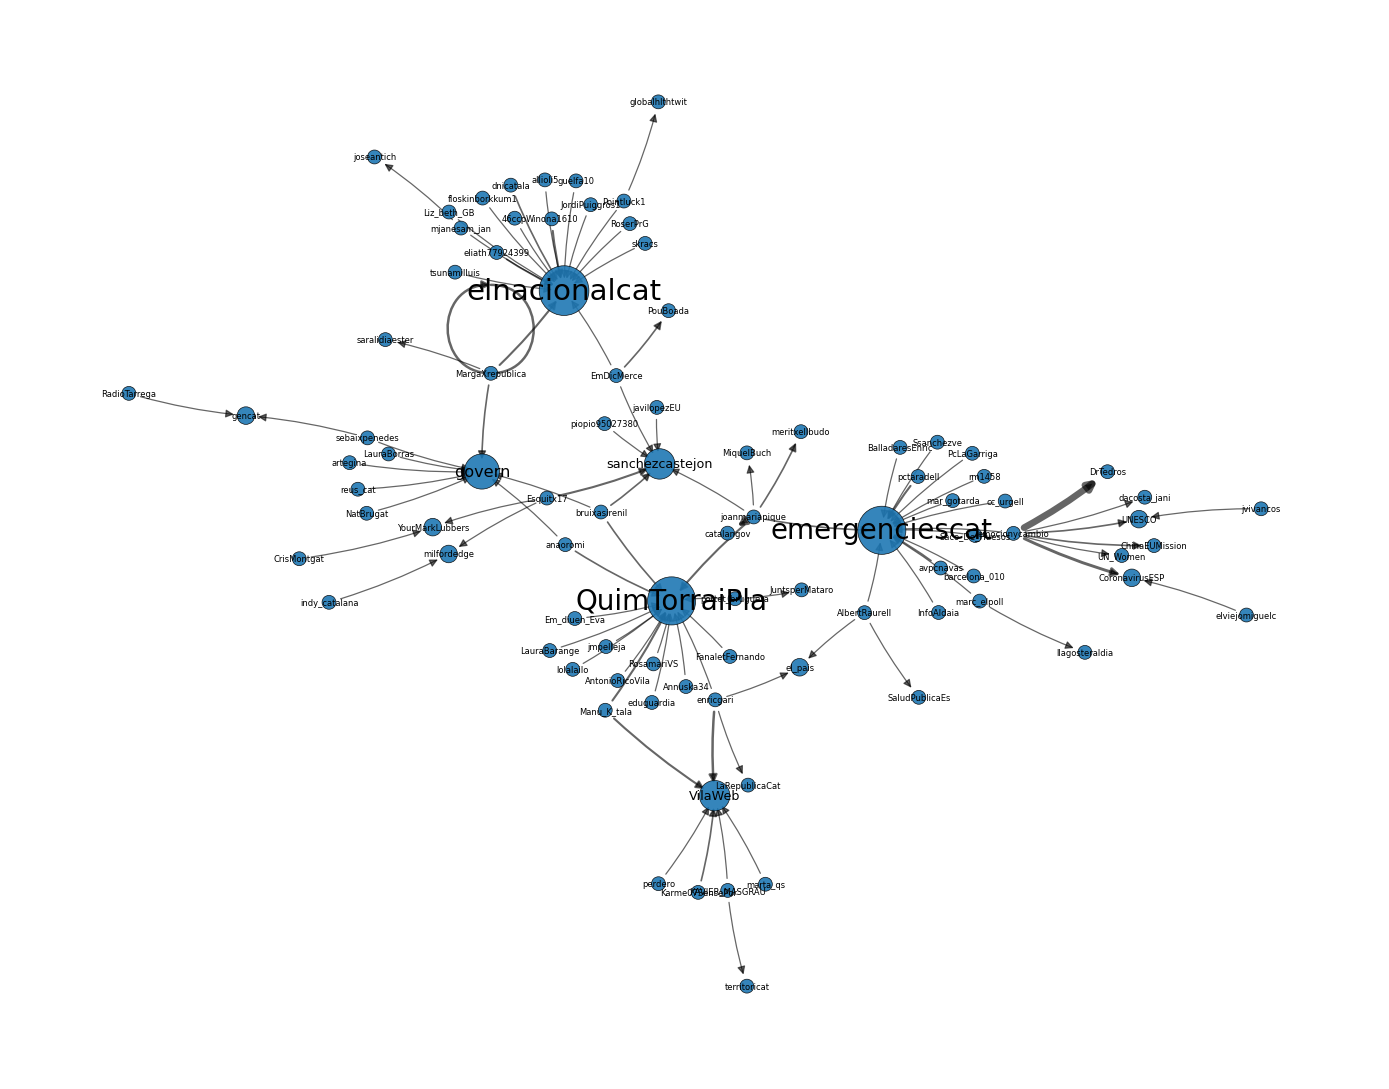

In [18]:
import matplotlib.pyplot as plt

nodes = list(lcc.nodes())
in_deg = dict(lcc.in_degree())                
node_sizes = [max(100, in_deg[n] * 80) for n in nodes]

label_sizes = {n: max(6, 2 + in_deg[n] * 1.2) for n in nodes}

edges = list(lcc.edges(data=True))
edge_widths = [max(0.6, e.get("weight", 1) * 0.3) for (_, _, e) in edges]

plt.figure(figsize=(14, 11))

nx.draw_networkx_nodes(
    lcc,
    pos,
    nodelist=nodes,
    node_size=node_sizes,
    linewidths=0.5,
    edgecolors="black",
    alpha=0.9,
)

nx.draw_networkx_edges(
    lcc,
    pos,
    edgelist=[(u, v) for (u, v, _) in edges],
    width=edge_widths,
    arrows=True,
    arrowstyle="-|>",
    arrowsize=12,
    connectionstyle="arc3,rad=0.05",
    alpha=0.6,
)


for n, (x, y) in pos.items():
    plt.text(
        x, y, s=str(n),
        fontsize=label_sizes[n],
        ha="center", va="center",
    )


plt.axis("off")
plt.tight_layout()
plt.savefig("mentions-largest-cc.png", dpi=300)
plt.show()

In [19]:
comps = list(nx.weakly_connected_components(g))


largest = max(comps, key=len)
second = sorted(comps, key=len, reverse=True)[1] if len(comps) > 1 else set()

diam = nx.diameter(g.subgraph(largest).to_undirected())


print("Diameter:", diam)
print("Largest component size:", len(largest))
print("Second largest component size:", len(second))
print("Largest component % of total:", len(largest)/g.number_of_nodes()*100)


Diameter: 10
Largest component size: 90
Second largest component size: 17
Largest component % of total: 25.210084033613445


The graph shows a few small groups of users that are connected to each other, but not many links between the groups. Most users only mention a few others, and there aren’t many strong connections across the whole network. The biggest group has a few main accounts in the center that get mentioned more, and the rest are smaller and less connected. Overall, it looks like people talk mostly inside their own circles.

When I remove the seed parameter and run the layout again, the graph looks a bit different each time. The nodes move around, but the overall structure stays the same. The seed parameter just makes the layout randomizer start in the same way every time, so if you use it, the graph always looks identical. Without it, the layout changes a little each time you run it.


## 2.3. Examine degree distributions


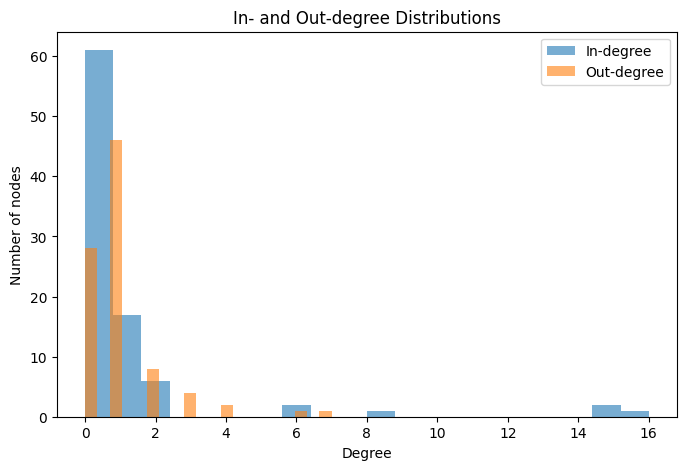

In [20]:
in_degrees = [d for n, d in lcc.in_degree()]
out_degrees = [d for n, d in lcc.out_degree()]

plt.figure(figsize=(8,5))
plt.hist(in_degrees, bins=20, alpha=0.6, label="In-degree")
plt.hist(out_degrees, bins=20, alpha=0.6, label="Out-degree")
plt.xlabel("Degree")
plt.ylabel("Number of nodes")
plt.legend()
plt.title("In- and Out-degree Distributions")
plt.show()


Most nodes have a low in-degree and out-degree, meaning they only mention a few others or get mentioned a few times. A small number of nodes have much higher degrees, showing that a few users are much more active or popular in the network.

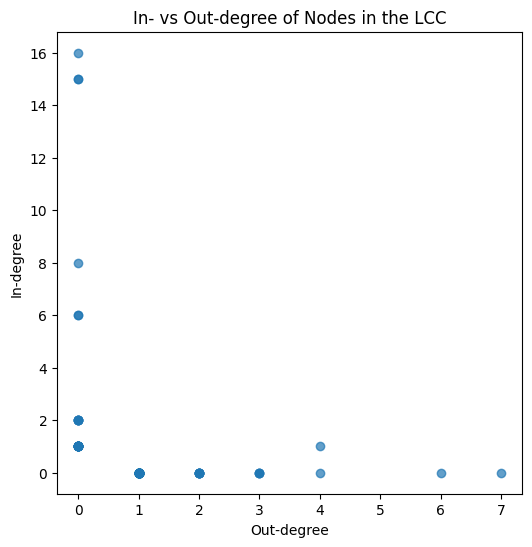

In [21]:
plt.figure(figsize=(6,6))
plt.scatter(out_degrees, in_degrees, alpha=0.7)
plt.xlabel("Out-degree")
plt.ylabel("In-degree")
plt.title("In- vs Out-degree of Nodes in the LCC")
plt.show()


The scatterplot shows the same pattern as before — most users have low in- and out-degrees, while only a few have high values. This means that most people interact with just a few others, and only a small number of users are very active or popular.

# 3. Create the undirected co-mention network


In [31]:
co_mentions_counter = {}

with gzip.open(COMPRESSED_INPUT_FILENAME, "rt", encoding="utf-8") as file:
    for line in file:
        tweet = json.loads(line)
        text = tweet.get("full_text", "")
        mentions = extract_mentions(text)
        mentions = list(set(m.lower() for m in mentions))

        for i in range(len(mentions)):
            for j in range(i + 1, len(mentions)):
                a = mentions[i]
                b = mentions[j]
                if a > b:
                    a, b = b, a

                pair = (a, b)
                if pair in co_mentions_counter:
                    co_mentions_counter[pair] += 1
                else:
                    co_mentions_counter[pair] = 1

I can't find the way for the code to give 8

In [32]:
# Leave this code as-is

print(co_mentions_counter[('educaciocat', 'elnacionalcat')])

4


In [34]:
rows = 0
with open(OUTPUT_CO_MENTIONS_FILENAME, "w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f, delimiter="\t")
    writer.writerow(["Source", "Target", "Weight"])
    for (a, b), w in co_mentions_counter.items():
        writer.writerow([a, b, w])
        rows += 1



In [35]:
rows = 0

with open(OUTPUT_CO_MENTIONS_FILENAME, "w", encoding="utf-8", newline="") as f:
    writer = csv.writer(f, delimiter="\t")
    writer.writerow(["Source", "Target", "Weight"])
    
    for (a, b), w in co_mentions_counter.items():
        writer.writerow([a, b, w])
        rows += 1

# 4. Visualize the undirected co-mention network 

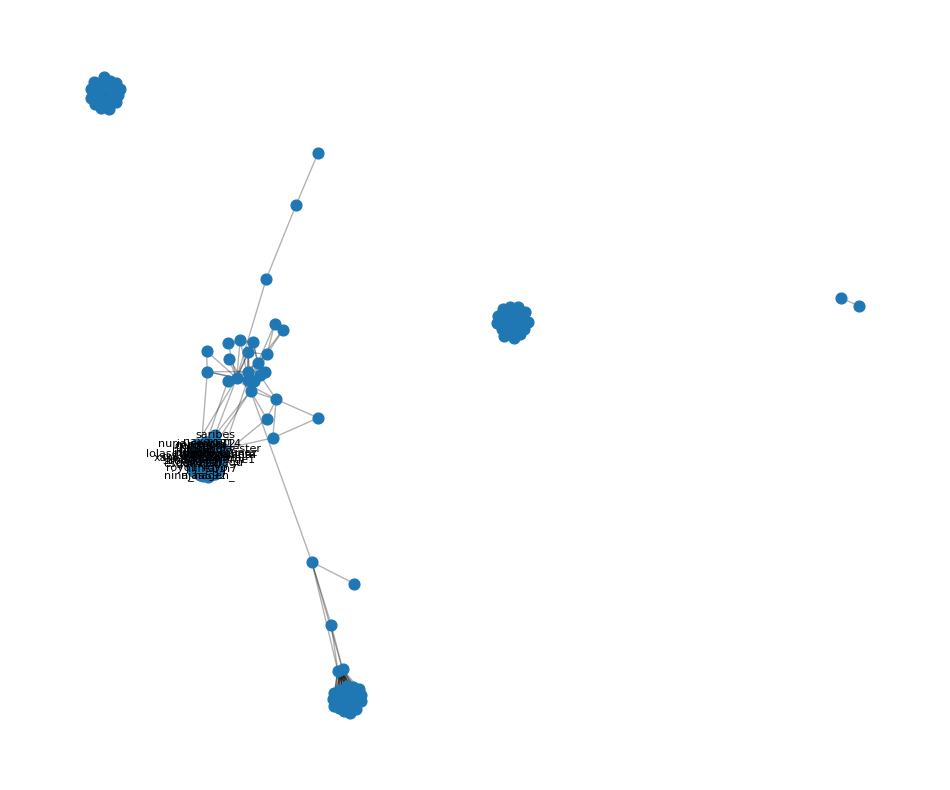

In [40]:
G = nx.Graph()
with open(OUTPUT_CO_MENTIONS_FILENAME, "r", encoding="utf-8") as f:
    r = csv.reader(f, delimiter="\t")
    next(r)
    for a, b, w in r:
        G.add_edge(a, b, weight=int(w))


deg_threshold = 17
H = G.subgraph([n for n, d in G.degree() if d >= deg_threshold]).copy()

if H.number_of_nodes() > 0:
    pos = nx.spring_layout(H, weight="weight", seed=42)
    plt.figure(figsize=(12, 10))
    nx.draw_networkx_edges(H, pos, alpha=0.3)
    nx.draw_networkx_nodes(H, pos, node_size=60)
    labels = {n: n for n, _ in sorted(H.degree(), key=lambda x: x[1], reverse=True)[:25]}
    nx.draw_networkx_labels(H, pos, labels=labels, font_size=8)
    plt.axis("off")
    plt.show()

The co-mention network shows a few big clusters where some accounts are mentioned together a lot. Most smaller groups are quite loose, but the largest connected component is much denser and includes the most popular or official accounts.
Overall, the network feels pretty connected, but still has clear smaller communities inside.

<font size="+2" color="#003300">I hereby declare that, except for the code provided by the course instructors, all of my code, text, and figures were produced by myself.</font>